In [14]:
# 투수 EDA

%run ../data_tools.ipynb
%run ../create_metrics.ipynb

      T_ID   GDAY_DS  HEADER_NO   P_ID  START_CK  BAT_ORDER_NO   PA   AB  RBI  \
0       HH  20160401          0  60404         0             3    1    1    0   
1       HH  20160401          0  62700         1             9    2    2    0   
2       HH  20160401          0  64086         1             7    6    4    0   
3       HH  20160401          0  66740         1             5    6    6    0   
4       HH  20160401          0  71347         1             2    6    6    1   
...    ...       ...        ...    ...       ...           ...  ...  ...  ...   
18679   WO  20161009          0  74215        91           374  402  341   80   
18680   WO  20161009          0  78168       139           177  646  560   63   
18681   WO  20161009          0  79130        15           251   80   66    7   
18682   WO  20161009          0  79300        13           429  106   91    9   
18683   WO  20161009          0  79365       122           965  454  411   70   

       RUN  ...  BB  IB  HP

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import xgboost
import shap

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from plotly.offline import plot
from plotly.offline import init_notebook_mode

init_notebook_mode(connected = True)


In [16]:
crawled_player_batter = pd.read_csv("../Crawler/crawled_player_batter.csv")
crawled_player_pitcher = pd.read_csv("../Crawler/crawled_player_pitcher.csv")
crawled_team_batter = pd.read_csv("../Crawler/crawled_team_batter.csv")
crawled_team_pitcher = pd.read_csv("../Crawler/crawled_team_pitcher.csv")
crawled_csum_player_pitcher = pd.read_csv("../Crawler/crawled_csum_player_pitcher.csv")

crawled_player_batter = crawled_player_batter.drop(["TB"], axis = "columns")
crawled_team_batter = crawled_team_batter.drop(["TB", "START_CK"], axis = "columns")
crawled_player_pitcher = crawled_player_pitcher.drop(["WHIP"], axis = "columns")
crawled_team_pitcher = crawled_team_pitcher.drop(["WHIP"], axis = "columns")
crawled_csum_player_pitcher = crawled_csum_player_pitcher.drop(["WHIP", "MONEY", "AGE_VA", "NAME"], axis = "columns")

In [17]:
total_data = []
for i in list(range(2016, 2021)) :
    rawData = load_data(i)
    Scaling_Money(rawData["player"])
    rawData["player_batter"] = pd.merge(rawData["player_batter"], rawData["player"][["P_ID", "T_ID", "AGE_VA", "MONEY", "NAME"]])
    rawData["player_pitcher"] = pd.merge(rawData["player_pitcher"], rawData["player"][["P_ID", "T_ID", "AGE_VA", "MONEY", "NAME"]])
    
    rawData["player_batter"] = rawData["player_batter"][crawled_player_batter.columns]
    rawData["player_pitcher"] = rawData["player_pitcher"][crawled_player_pitcher.columns]
    rawData["team_batter"] = rawData["team_batter"][crawled_team_batter.columns]
    rawData["team_pitcher"] = rawData["team_pitcher"][crawled_team_pitcher.columns]
    rawData["csum_player_pitcher"] = rawData["csum_player_pitcher"][crawled_csum_player_pitcher.columns]
    
    if i == 2020 :
        rawData["player_batter"] = pd.concat([rawData["player_batter"], crawled_player_batter]).reset_index(drop = True)
        rawData["player_pitcher"] = pd.concat([rawData["player_pitcher"], crawled_player_pitcher]).reset_index(drop = True)
        rawData["team_batter"] = pd.concat([rawData["team_batter"], crawled_team_batter]).reset_index(drop = True)
        rawData["team_pitcher"] = pd.concat([rawData["team_pitcher"], crawled_team_pitcher]).reset_index(drop = True)
        rawData["csum_player_pitcher"] = pd.concat([rawData["csum_player_pitcher"], crawled_csum_player_pitcher]).reset_index(drop = True)
        
    make_batter_metrics(rawData, "player_batter")
    make_batter_metrics(rawData, "team_batter")
    make_pitcher_metrics(rawData, "player_pitcher")
    make_pitcher_metrics(rawData, "team_pitcher")
    total_data.append(rawData)

tableList = []
for key in total_data[0].keys() :
    tableList.append(key)

final_data = dict()
for key in tableList :
    final_data[key] = pd.DataFrame()

for year in range(len(total_data)) :
    for key in tableList :
        if final_data[key].empty :
            final_data[key] = total_data[year][key]
        else :
            final_data[key] = pd.concat([final_data[key], total_data[year][key]], axis = 0)
            
for key in final_data.keys() :
    final_data[key].reset_index(drop = True)

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:134: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning:

In [18]:
# 세이버 메트릭스 대부분의 지표는 선수 개인을 대상으로 합니다.
# 예측은 팀 단위로 이루어지기 때문에 선수 데이터를 바탕으로 팀을 대표할 수 있도록
# 각 선수의 세이버 메트릭스 지표에 대해 타자의 경우 타석 수, 투수의 경우 이닝 수를 기준으로
# 경기 별 각 선수의 가중 평균을 해당 경기의 팀 스탯으로 나타냈습니다.

final_data["player_pitcher"].rename(columns = {"MONEY" : "MONEY_PIT", "AGE_VA" : "AGE_VA_PIT"}, inplace = True)
final_data["player_pitcher"] = final_data["player_pitcher"].reset_index(drop = True)

metrics_pitcher = ["BB/9", "LOB%", "FIP", "DER", "ERC", "ERA", "WHIP", "RA/9", "MONEY_PIT", "AGE_VA_PIT"]
final_data["player_pitcher"].sort_values(by = ["T_ID", "GDAY_DS", "HEADER_NO"])
final_data["player_pitcher"] = final_data["player_pitcher"].reset_index(drop = True)

result = final_data["player_pitcher"].groupby(["GDAY_DS", "T_ID", "HEADER_NO"])["INN2"].sum()
result = result.to_frame().dropna().reset_index()
result.rename(columns = {"INN2" : "INN2_SUM"}, inplace = True)
result

final_data["team_pitcher"] = pd.get_dummies(final_data["team_pitcher"], columns = ["WLS"], drop_first = True)

final_data["player_pitcher"] = pd.merge(final_data["player_pitcher"], result)
final_data["player_pitcher"][metrics_pitcher] = final_data["player_pitcher"][metrics_pitcher].mul((final_data["player_pitcher"]["INN2"] / final_data["player_pitcher"]["INN2_SUM"]), axis = 0)
final_data["player_pitcher"] = final_data["player_pitcher"].drop("INN2_SUM", axis = "columns")
final_data["player_pitcher"] = final_data["player_pitcher"][final_data["player_pitcher"]["INN2"] != 0]
final_data["player_pitcher"] = final_data["player_pitcher"][~np.isinf(final_data["player_pitcher"]["LOB%"])]
final_data["player_pitcher"]

,GDAY_DS,START_CK,INN2,R,ER,PA,AB,HIT,H2,H3,...,K/9,BB/9,LOB%,FIP,WHIP,RA/9,DER,ERC,ERA,PPF
0,20160401,0,6.0,0.0,0.0,8.0,7.0,1.0,0.0,0.0,...,1.500000,0.083333,0.166667,-0.202297,0.166667,0.000000,0.125000,-0.006595,0.000000,NaN
1,20160401,0,5.0,0.0,0.0,8.0,6.0,2.0,0.0,0.0,...,0.600000,0.083333,0.138889,0.123086,0.250000,0.000000,0.092593,0.112715,0.000000,0.876596
2,20160401,0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,...,0.000000,0.000000,0.027778,0.010982,0.083333,0.000000,0.013889,0.104118,0.000000,0.906066
3,20160401,1,18.0,4.0,4.0,28.0,25.0,9.0,2.0,0.0,...,0.666667,0.083333,0.300000,-0.218992,0.833333,0.333333,0.304348,0.566746,0.333333,0.882331
4,20160401,0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,...,1.000000,0.000000,NaN,-0.145229,0.000000,0.000000,0.083333,-0.046667,0.000000,0.769309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30030,20200916,0,9.0,0.0,0.0,11.0,10.0,1.0,0.0,0.0,...,1.000000,0.111111,0.333333,-0.206499,0.222222,0.000000,0.285714,-0.074870,0.000000,NaN
30031,20200919,0,1.0,4.0,4.0,5.0,3.0,2.0,0.0,0.0,...,0.000000,0.125000,0.000000,0.768473,0.375000,0.500000,0.013889,0.695360,0.500000,NaN
30032,20200919,0,6.0,1.0,0.0,8.0,7.0,2.0,1.0,0.0,...,1.500000,0.125000,0.166667,-0.281073,0.375000,0.125000,0.125000,0.079289,0.000000,NaN
30033,20200919,1,15.0,2.0,1.0,19.0,17.0,4.0,0.0,0.0,...,0.200000,0.125000,0.375000,0.389252,0.625000,0.250000,0.477941,0.012582,0.125000,NaN


In [19]:
# 각 선수별 스탯의 가중평균으로 나타낸 팀 스탯을 별도로 저장했습니다.

pitcher = final_data["player_pitcher"].groupby(["GDAY_DS", "T_ID", "HEADER_NO"]).sum()
pitcher.rename(columns = {"ERA" : "ERA_WEIGHTED"}, inplace = True)
pitcher = pitcher.drop(["START_CK", "PPF"], axis = "columns")
pitcher = pitcher.dropna(axis = 0).reset_index(inplace = False)

pitcher = pd.merge(pitcher, final_data["team_pitcher"][["GDAY_DS", "T_ID", "HEADER_NO", "PPF", "ERA", "WLS_W"]])
pitcher = pitcher.sort_values(by = ["T_ID", "GDAY_DS"]).reset_index(inplace = False, drop = True)
pitcher.describe()

,GDAY_DS,HEADER_NO,INN2,R,ER,PA,AB,HIT,H2,H3,...,LOB%,FIP,WHIP,RA/9,DER,ERC,ERA_WEIGHTED,PPF,ERA,WLS_W
count,6.899000e+03,6899.000000,6899.000000,6899.000000,6899.000000,6899.000000,6899.000000,6899.000000,6899.000000,6899.000000,...,6899.000000,6899.000000,6899.000000,6899.000000,6899.000000,6899.000000,6899.000000,6709.000000,6899.000000,6899.000000
mean,2.017979e+07,0.009132,26.478620,5.034643,4.610378,38.846644,34.335266,9.501667,1.670242,0.143499,...,0.691050,1.577353,1.459775,0.581306,0.709957,1.174922,0.532324,0.880008,0.549459,0.494130
std,1.380966e+04,0.121854,2.959169,3.521765,3.366057,5.925699,4.955171,3.750224,1.375172,0.381497,...,0.188587,2.059114,0.539611,0.423394,0.089956,1.117334,0.404219,0.091348,0.408159,0.500002
min,2.016040e+07,0.000000,2.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,...,-0.191358,-3.508880,0.000000,0.000000,0.000000,-0.560000,0.000000,0.526465,0.000000,0.000000
25%,2.017050e+07,0.000000,24.000000,2.000000,2.000000,35.000000,31.000000,7.000000,1.000000,0.000000,...,0.568182,0.107778,1.111111,0.250000,0.649523,0.388668,0.222222,0.825540,0.222222,0.000000
50%,2.018060e+07,0.000000,27.000000,4.000000,4.000000,38.000000,34.000000,9.000000,1.000000,0.000000,...,0.691358,1.267519,1.400000,0.500000,0.711111,0.950487,0.444444,0.877611,0.444444,0.000000
75%,2.019070e+07,0.000000,27.000000,7.000000,6.000000,42.000000,37.000000,12.000000,2.000000,0.000000,...,0.809524,2.688399,1.777778,0.777778,0.771605,1.699830,0.750000,0.921665,0.777778,1.000000
max,2.020092e+07,2.000000,54.000000,26.000000,24.000000,87.000000,75.000000,29.000000,9.000000,3.000000,...,4.111111,36.339531,5.000000,4.500000,1.000000,21.232206,4.500000,2.259985,4.500000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002CCB888F308>,
      dtype=object)

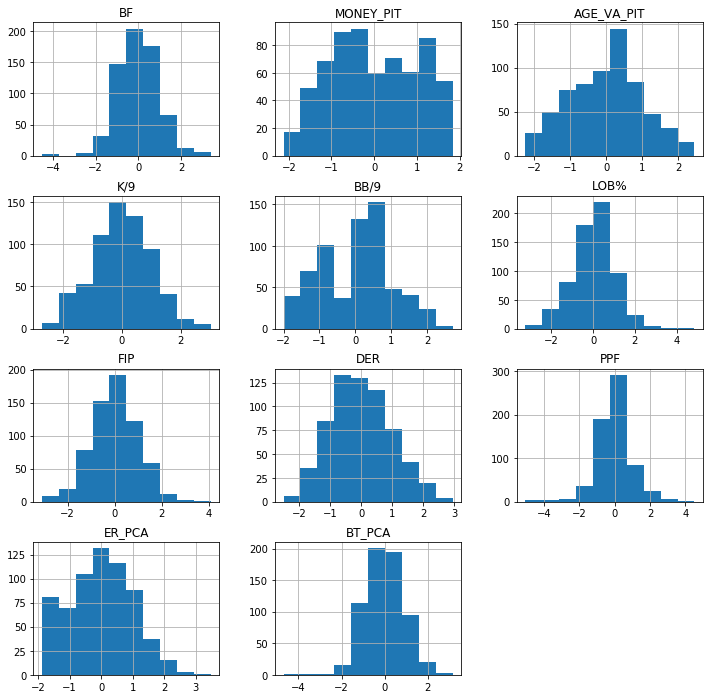

In [33]:
target = pitcher[pitcher["T_ID"] == "LT"].dropna().ERA[20:].reset_index(drop = True)

scaler = MinMaxScaler()
feature = pitcher[pitcher["T_ID"] == "LT"].dropna().drop(["GDAY_DS", "T_ID", "HEADER_NO", "H3", "IB", "WLS_W",
                                                          "BB", "KK", "HP", "H2", "INN2", "HR"], axis = "columns").reset_index(drop = True)

pca = PCA(n_components = 1)
res = pca.fit_transform(feature[["ERA", "R", "ER", "RA/9", "ERA_WEIGHTED", "WHIP", "ERC"]])
feature["ER_PCA"] = res
feature = feature.drop(["ERA", "R", "ER", "RA/9", "ERA_WEIGHTED", "WHIP", "ERC"], axis = "columns")

pca = PCA(n_components = 1)
res = pca.fit_transform(feature[["PA", "AB", "HIT"]])
feature["BT_PCA"] = res
feature = feature.drop(["PA", "AB", "HIT"], axis = "columns")

feature = pd.DataFrame(power_transform(feature, method = "yeo-johnson"), columns = feature.columns, index = feature.index.values)
feature = feature.loc[0:len(target)-1]
feature.hist(figsize = (12, 12))

In [34]:
feature.skew()

BF            0.036202
MONEY_PIT    -0.006309
AGE_VA_PIT   -0.022512
K/9           0.014366
BB/9         -0.004425
LOB%          0.006363
FIP           0.073675
DER           0.233252
PPF          -0.170435
ER_PCA        0.088738
BT_PCA       -0.279435
dtype: float64

In [35]:
feature.describe()

,BF,MONEY_PIT,AGE_VA_PIT,K/9,BB/9,LOB%,FIP,DER,PPF,ER_PCA,BT_PCA
count,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000
mean,-0.011508,-0.001656,-0.005664,-0.009664,0.006661,0.007752,0.008140,-0.000845,0.001113,-0.004396,-0.013880
std,0.935806,1.002176,1.001874,0.996189,1.000366,1.001899,1.001381,0.976317,1.008458,0.998650,0.917784
min,-4.519863,-2.121928,-2.246765,-2.718324,-2.000858,-3.244070,-3.100700,-2.504031,-5.036035,-1.886519,-4.687179
25%,-0.650497,-0.811855,-0.754559,-0.637204,-0.649130,-0.622115,-0.631089,-0.736168,-0.577377,-0.739603,-0.628198
50%,0.005461,-0.090790,0.099311,0.019902,-0.100581,0.050691,0.013617,-0.078604,0.044272,0.011843,-0.024122
75%,0.523994,0.900911,0.632764,0.631464,0.607948,0.639196,0.643507,0.670049,0.545530,0.708428,0.586788
max,3.391576,1.837301,2.454862,3.019363,2.713626,4.856276,4.090926,2.950499,4.513378,3.482052,3.151505


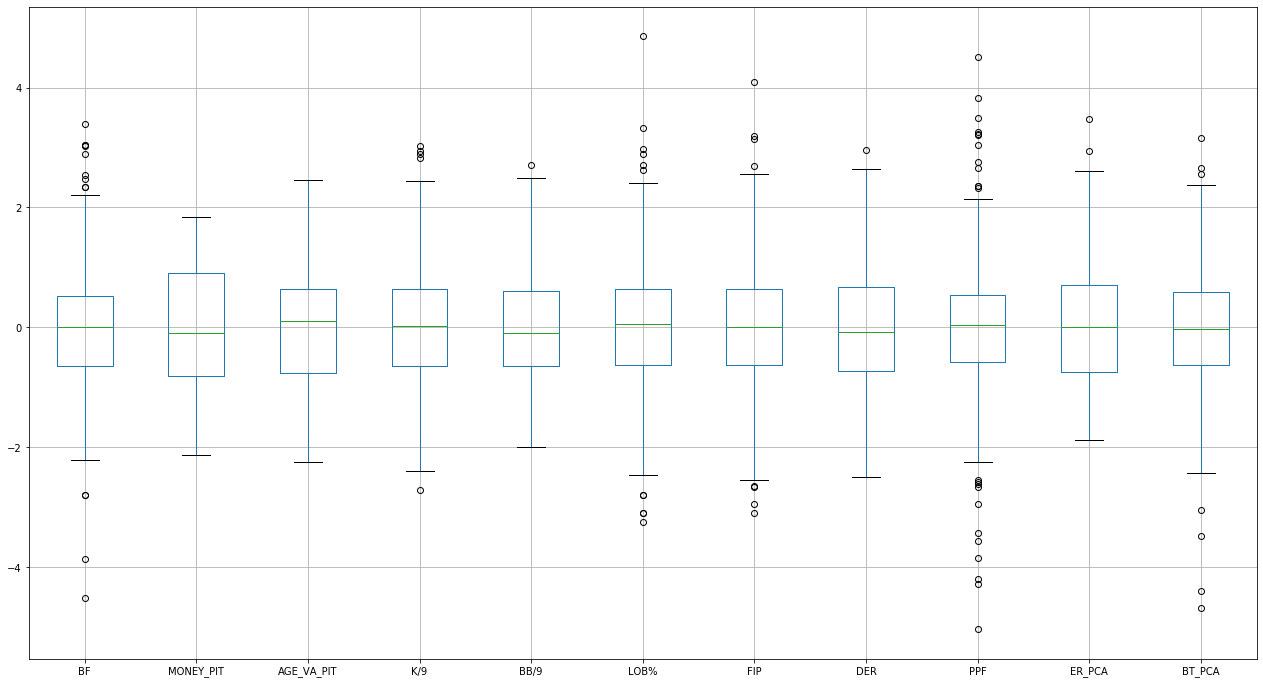

In [36]:
feature.boxplot(figsize = (22, 12))

In [37]:
feature.corr(method = "pearson")

,BF,MONEY_PIT,AGE_VA_PIT,K/9,BB/9,LOB%,FIP,DER,PPF,ER_PCA,BT_PCA
BF,1.000000,-0.125262,-0.037878,0.465543,0.489225,-0.141889,0.309291,-0.414792,-0.011685,0.519977,0.799270
MONEY_PIT,-0.125262,1.000000,0.414959,-0.077740,-0.159998,0.109842,-0.184956,0.048697,-0.027485,-0.187052,-0.088664
AGE_VA_PIT,-0.037878,0.414959,1.000000,0.067385,-0.083766,-0.022910,-0.070316,0.019610,-0.019086,-0.045324,-0.016771
K/9,0.465543,-0.077740,0.067385,1.000000,0.174547,-0.090027,-0.086210,-0.257866,-0.014894,0.114353,0.313653
BB/9,0.489225,-0.159998,-0.083766,0.174547,1.000000,-0.095162,0.482160,-0.185231,0.024302,0.391104,0.260893
LOB%,-0.141889,0.109842,-0.022910,-0.090027,-0.095162,1.000000,-0.111491,0.184821,-0.063483,-0.525759,-0.199176
FIP,0.309291,-0.184956,-0.070316,-0.086210,0.482160,-0.111491,1.000000,-0.089601,-0.007940,0.644839,0.350922
DER,-0.414792,0.048697,0.019610,-0.257866,-0.185231,0.184821,-0.089601,1.000000,0.034549,-0.534199,-0.575462
PPF,-0.011685,-0.027485,-0.019086,-0.014894,0.024302,-0.063483,-0.007940,0.034549,1.000000,-0.016858,-0.042220
ER_PCA,0.519977,-0.187052,-0.045324,0.114353,0.391104,-0.525759,0.644839,-0.534199,-0.016858,1.000000,0.664866


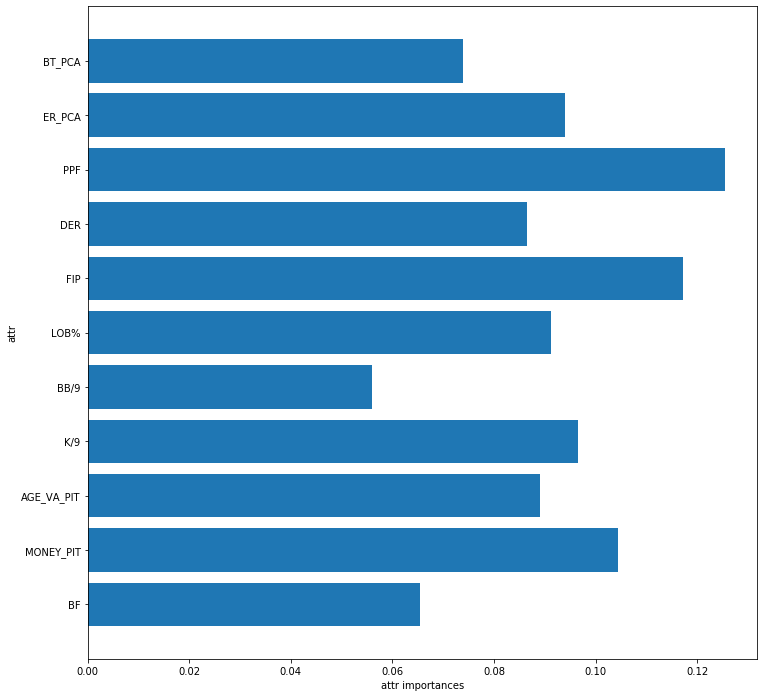

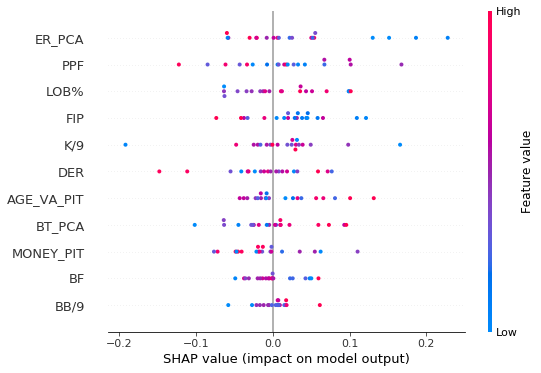

In [38]:
# Find Feature - GBRT
trainFeature = feature.loc[0:feature.shape[0]-20]
trainTarget = target.loc[0:feature.shape[0]-20]

testFeature = feature.loc[feature.shape[0]-20:].reset_index(drop = True)
testTarget = target[feature.shape[0]-20:].reset_index(drop = True)

tree = GradientBoostingRegressor(max_depth = 5,learning_rate = 0.1, n_estimators = 500, subsample = 0.8)
tree.fit(trainFeature, trainTarget)

tree.score(testFeature, testTarget)


n_features = trainFeature.shape[1]

plt.figure(figsize = (12, 12))
plt.barh(range(n_features), tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), testFeature.columns)
plt.xlabel("attr importances")
plt.ylabel("attr")
plt.ylim(-1, n_features)
plt.show()

explainer = shap.TreeExplainer(tree, trainFeature)
shap_values = explainer.shap_values(testFeature, check_additivity = False)
shap.summary_plot(shap_values, testFeature)


In [39]:
# Find Feature - GBRT

result = tree.predict(testFeature)
result = result.reshape(testTarget.shape[0])

result.mean()

0.6140494997291941

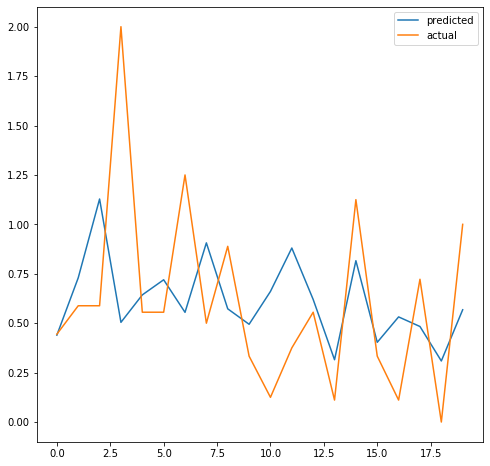

In [40]:

plt.figure(figsize = (8, 8))
plt.plot(result, label = "predicted")
plt.plot(testTarget, label = "actual")
plt.legend()
